In this notebook, I evaluate different time series models and save the metrics for each of the model to compare them against one another. Afterwards, I save the best performing model into pickle files to make predictions for my web app.

# Table of Contents
1. [Imports](#section1)
2. [Prepare DataFrame](#section2)
3. [Time Series Model Evaluation](#section3)
4. [Model Error](#section4)
5. [Save Final Models](#section5)

<a id='section1'></a>

### 1. Imports

In [94]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import pickle

%matplotlib inline

In [95]:
# time series imports
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima

import fbprophet

<a id='section2'></a>

### 2. Prepare DataFrame

First, I'll need to prep my visitor dataframe into a format that's useful for time series. I'll start off by just cleaning up Yosemite's dataframe.

In [96]:
# using the Yosemite data as an example
yosemite_df = pd.read_pickle("visitor_data/YOSE.pickle")

# clean up data and turn values into integers
yosemite_df.iloc[:,1:] = yosemite_df.iloc[:,1:].replace("\xa0", 0)
yosemite_df = yosemite_df.replace(",", '', regex=True).astype(int)

# impute low, zero, or missing values with the mean
for column in yosemite_df.columns.tolist()[1:]:
    yosemite_df[column] = yosemite_df[column].map(lambda x: int(yosemite_df[column].mean()) if x < 100 else x)

yosemite_df.set_index("Year", inplace=True)

yosemite_df.head()

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,Total
Year,,,,,,,,,,,,,
2020,132742,167778,136305,203944,330180,236260,469192,556572,428354,307513,149609,111929,1005972
2019,116746,111665,173610,297207,393004,496625,717462,703153,584664,448939,230598,149188,4422861
2018,129432,143321,170681,278349,385670,543690,504230,441867,524387,360776,215854,311179,4009436
2017,120025,119421,166793,302553,471844,565702,633351,615892,566279,429827,217927,127276,4336890
2016,139780,201601,286990,305092,457309,703614,780728,692450,598428,483232,218998,160646,5028868


In [97]:
park_df = pd.DataFrame(yosemite_df.drop(columns=["Total"]).stack(), columns=["num_visitors"])

# turn year and month strings into a datetime object
park_df.index = [(str(idx[0]) + " " + idx[1]) for idx in park_df.index]
park_df.index = pd.to_datetime(park_df.index, format="%Y %b")

# remove all visitor values past March 2020 due to the coronavirus pandemic
park_df = park_df[park_df.index < '2020-02-02']
park_df.sort_index(ascending=True, inplace=True)

park_df.head()

,num_visitors
1979-01-01,72701
1979-02-01,72926
1979-03-01,87950
1979-04-01,136275
1979-05-01,210756


<a id='section3'></a>

### 3. Time Series Model Evaluation

The Time Series models I want to evaluate are:
* ARIMA
* SARIMA
* FB Prophet

First, I need to split my data into a training and testing set. I also want to define a metric, in this case mean absolute percent error, to evaluate how good each model's predictions are.

In [98]:
def split_train_test(data, months: int):
    '''
    Split data into a training and testing set based on the number of months from the end date.
    For example, if months awas 12, the data would be split into the last 12 months of the dataset and the rest
    of the data.
    
    Parameters:
    ------------
    - data: Dataframe with data to split into training and testing
    - months: number of months to split the data into
    
    Returns:
    --------
    - train_data: Dataframe of training data
    - test_data: Dataframe of testing data
    
    '''
    train_data = data.copy().iloc[:len(data)-months]
    test_data = data.copy().iloc[len(data)-months:]
    
    return train_data, test_data

In [99]:
# metric to gauge model performance
def mape(y_true, y_pred):
    '''
    Returns the mean absolute percent error between the actual and predicted values.
    
    Parameters:
    -----------
    - y_true: the actual values
    - y_pred: the model's predicted values
    
    Returns:
    --------
    - the mean absolute percent error between the actual and predicted values  
    '''
    
    # reshape to make them the same shape
    y_true = np.array(y_true).reshape(-1, 1)
    y_pred = np.array(y_pred).reshape(-1, 1)
    
    error = (y_true - y_pred) / y_true
    return np.mean(np.abs(error)) * 100

Using AutoARIMA to find the best model with lowest AIC. AIC is Akaike's Information Criterion.

In [100]:
# train on everything up to 48 months or 4 years
park_train, park_test = split_train_test(park_df, 48)

In [101]:
best_arima = auto_arima(park_train["num_visitors"].values, start_p = 1, start_q = 1,
                        test='adf', max_p = 3, max_q = 3, m=1, d=None, seasonal=False,
                        start_P=0, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
best_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11365.515, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12604.594, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11526.466, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12264.158, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11274.092, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11272.421, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11273.725, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11274.613, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=11107.810, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11500.644, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=11034.305, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=11034.910, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=11129.373, Time=0.22 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 1.187 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  446
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -5512.152
Date:                Sat, 12 Sep 2020   AIC                          11034.305
Time:                        16:34:36   BIC                          11054.806
Sample:                             0   HQIC                         11042.388
                                - 446                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.124e+05   6758.823     16.637      0.000    9.92e+04    1.26e+05
ar.L1          1.1758      0.045     25.897      0.000       1.087       1.265
ar.L2         -0.1787      0.079     -2.271      0.023      -0.333      -0.024
ar.L3         -0.3963      0.049     -8.043      0.000      -0.493      -0.300
sigma2      3.162e+09      0.055   5.78e+10      0.000    3.16e+09    3.16e+09
===================================================================================
Ljung-Box (Q):                      901.75   Jarque-Bera (JB):                 6.95
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               0.75   Skew:                             0.01
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.32e+27. Standard errors may be unstable.
"""

In [102]:
# evaluate model
n_periods = 48
arima_predictions = best_arima.predict(n_periods=n_periods)

In [104]:
# pretty bad, 50% error
arima_mape = mape(park_test["num_visitors"].values, arima_predictions)
arima_mape

50.24949797173145

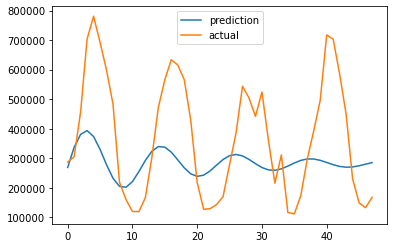

In [105]:
# plot predicted values vs actual values
comparison = pd.DataFrame(arima_predictions)
comparison["actual"] = pd.Series(park_test["num_visitors"].values, index=comparison.index)
comparison = comparison.rename(columns={0:"prediction"})
comparison.plot();

I've tried ARIMA without seasonality, but what about SARIMA with seasonality?

In [106]:
best_sarima = auto_arima(park_train["num_visitors"].values, start_p = 1, start_q = 1,
                        test='adf', max_p = 3, max_q = 3, m=12, d=None, seasonal=True, disp=-1,
                        start_P=0, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
best_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=10235.772, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=10336.282, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10245.842, Time=0.23 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=10261.408, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=10340.748, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=10289.603, Time=0.14 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=10237.641, Time=0.62 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=10237.315, Time=0.83 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=10245.823, Time=0.38 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=10238.038, Time=1.81 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=10235.696, Time=0.25 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10287.901, Time=0.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=10237.305, Time=0.40 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=10237.137, Time=0.64 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  446
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -5112.505
Date:                              Sat, 12 Sep 2020   AIC                          10235.011
Time:                                      16:35:04   BIC                          10255.376
Sample:                                           0   HQIC                         10243.050
                                              - 446                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2859.5396   1038.042      2.755      0.006     825.014    4894.065
ar.L1          0.4825      0.045     10.762      0.000       0.395       0.570
ar.L2          0.0835      0.053      1.580      0.114      -0.020       0.187
ma.S.L12      -0.4344      0.033    -13.249      0.000      -0.499      -0.370
sigma2       1.14e+09      0.004   2.63e+11      0.000    1.14e+09    1.14e+09
===================================================================================
Ljung-Box (Q):                       63.37   Jarque-Bera (JB):               228.40
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.28
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.7e+26. Standard errors may be unstable.
"""

In [107]:
# evaluate model
n_periods = 48
sarima_predictions = best_sarima.predict(n_periods=n_periods)

In [108]:
# not bad, 17% error
sarima_mape = mape(park_test["num_visitors"].values, sarima_predictions)
sarima_mape

17.022279733249192

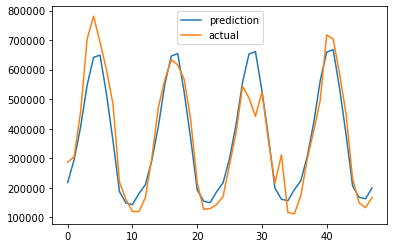

In [109]:
comparison = pd.DataFrame(sarima_predictions)
comparison["actual"] = pd.Series(park_test["num_visitors"].values, index=comparison.index)
comparison = comparison.rename(columns={0:"prediction"})
comparison.plot();

Now to try FB Prophet

In [110]:
fb_model = fbprophet.Prophet()

In [111]:
park_train_df = park_train.reset_index()
park_train_df.columns=["ds", "y"]
fb_model.fit(park_train_df)

park_train_df.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,y
0,1979-01-01,72701
1,1979-02-01,72926
2,1979-03-01,87950
3,1979-04-01,136275
4,1979-05-01,210756


In [112]:
future = fb_model.make_future_dataframe(periods=48, freq='m')
forecast = fb_model.predict(future)
fb_predictions = forecast[['yhat']].tail(48)['yhat'].values.tolist()

In [114]:
# not bad, 20% error
fb_prophet_mape = mape(park_test["num_visitors"].values, fb_predictions)
fb_prophet_mape

20.149310479192376

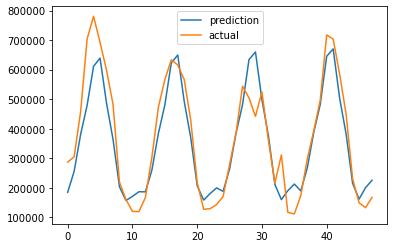

In [115]:
comparison = pd.DataFrame(fb_predictions)
comparison["actual"] = pd.Series(park_test["num_visitors"].values, index=comparison.index)
comparison = comparison.rename(columns={0:"prediction"})
comparison.plot();

In [149]:
# keep track of the errors for each model and save them to a dataframe
error_dict = {"park": "YOSE", "ARIMA_mape": arima_mape, 
              "SARIMA_mape": sarima_mape, "FB_Prophet_mape": fb_prophet_mape}

In [150]:
pd.DataFrame(error_dict, index=[0])

,park,ARIMA_mape,SARIMA_mape,FB_Prophet_mape
0,YOSE,50.249498,17.02228,20.14931


<a id='section4'></a>

### 4. Model Error

Now that I know how to evaluate models for one national park, I can create functions to evaluate the top 10 most visited national visitor counts using different time series models.

In [49]:
def prep_data(park_code):
    '''
    Clean and prep the dataframe related to the park code for time series modeling.
    Years and month data needs to be combined into a datetime object, missing or low values
    are imputed, and visitor counts are turned into an integer.
    
    Parameters:
    -----------
    - park_code: the 4 letter code corresponding to a park, such as "YOSE" for Yosemite
    
    Returns:
    --------
    - park_df: Dataframe with date and visitor count formatted to do time series modeling
    '''
    
    # read in the dataframe
    park_df = pd.read_pickle(f"visitor_data/{park_code}.pickle")
    
    # clean up visitor number values and turn them into integers
    park_df.iloc[:,1:] = park_df.iloc[:,1:].replace("\xa0", 0)
    park_df = park_df.replace(",", '', regex=True).astype(int)
    
    # impute visitor values less than 100 with the mean visitor count of that month
    for column in park_df.columns.tolist()[1:]:
        park_df[column] = park_df[column].map(lambda x: int(park_df[column].mean()) 
                                              if x < 100 else x)
    
    # make the index the date so that all values in the dataframe are visitor counts
    park_df.set_index("Year", inplace=True)
    park_df.drop(columns=["Total"], inplace=True)
    
    # make the visitor counts into one column
    park_df = pd.DataFrame(park_df.stack(), columns=["num_visitors"])
    
    park_df.index = [(str(idx[0]) + " " + idx[1]) for idx in park_df.index]
    park_df.index = pd.to_datetime(park_df.index, format="%Y %b")
    
    # remove dates after February 2020 due to the coronavirus pandemic
    park_df = park_df[park_df.index < '2020-02-02']
    park_df.sort_index(ascending=True, inplace=True)
    
    return park_df

In [50]:
def evaluate_models(data, months, park_code):
    '''
    Evaluate different time series models based on mean absolute percent error and save the values
    into a dictionary.
    
    Parameters:
    -----------
    - data: (generally refers to output from the prep_data function) a cleaned dataframe
            with date and visitor counts
    - months: the number of months to split the data into training and testing sets
    - park_code: the 4 letter code corresponding to a park, such as "YOSE" for Yosemite
    
    Returns:
    --------
    - error_dict: a dictionary that capture the mean absolute percent error for 3 different time series models
                  on the data
    
    '''
    error_dict = {}
    
    train_data, test_data = split_train_test(data, months)
    
    arima_mape = arima_error(train_data, test_data, months)
    sarima_mape = sarima_error(train_data, test_data, months)
    fb_prophet_mape = fb_prophet_error(train_data, test_data, months)
    
    
    error_dict["park_code"] = park_code
    error_dict["ARIMA_mape"] = arima_mape
    error_dict["SARIMA_mape"] = sarima_mape
    error_dict["FB_Prophet_mape"] = fb_prophet_mape
    
    return error_dict

In [51]:
def arima_error(train_data, test_data, months):
    '''
    Fit an ARIMA model to the data and return the mean absolute percent error for the prediction
    
    Parameters:
    -----------
    - train_data: the training data (date and visitor counts) after splitting the original dataset
    - test_data: the testing data (date and visitor counts) after splitting the original dataset
    
    Returns:
    --------
    - arima_mape: mean absolute percent error for an ARIMA model fit to the data
    '''
    
    best_arima = auto_arima(train_data["num_visitors"].values, start_p = 1, start_q = 1,
                        test='adf', max_p = 3, max_q = 3, m=1, d=None, seasonal=False, disp=-1,
                        start_P=0, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    
    arima_predictions = best_arima.predict(n_periods=months)
    arima_mape = mape(test_data["num_visitors"].values, arima_predictions)
    
    return arima_mape

In [52]:
def sarima_error(train_data, test_data, months):
    '''
    Fit a SARIMA model to the data and return the mean absolute percent error for the prediction
    
    Parameters:
    -----------
    - train_data: the training data (date and visitor counts) after splitting the original dataset
    - test_data: the testing data (date and visitor counts) after splitting the original dataset
    
    Returns:
    --------
    - sarima_mape: mean absolute percent error for a SARIMA model fit to the data
    '''
    
    best_sarima = auto_arima(train_data["num_visitors"].values, start_p = 1, start_q = 1,
                        test='adf', max_p = 3, max_q = 3, m=12, d=None, seasonal=True,
                        start_P=0, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    
    sarima_predictions = best_sarima.predict(n_periods=months)
    sarima_mape = mape(test_data["num_visitors"].values, sarima_predictions)
    
    return sarima_mape

In [53]:
def fb_prophet_error(train_data, test_data, months):
    '''
    Fit a FB Prophet model to the data and return the mean absolute percent error for the prediction
    
    Parameters:
    -----------
    - train_data: the training data (date and visitor counts) after splitting the original dataset
    - test_data: the testing data (date and visitor counts) after splitting the original dataset
    
    Returns:
    --------
    - fb_mape: mean absolute percent error for a FB Prophet model fit to the data
    '''
    
    fb_model = fbprophet.Prophet()
    
    park_train_df = train_data.copy()
    park_train_df = park_train_df.reset_index()
    park_train_df.columns=["ds", "y"]
    
    fb_model.fit(park_train_df)
    
    future = fb_model.make_future_dataframe(periods=months, freq='m')
    forecast = fb_model.predict(future)
    fb_predictions = forecast[['yhat']].tail(48).values.tolist()
    
    fb_mape = mape(test_data["num_visitors"].values, fb_predictions)
    
    return fb_mape

In [169]:
top_10_park_codes = ['ACAD',
 'GLAC',
 'GRCA',
 'GRTE',
 'GRSM',
 'OLYM',
 'ROMO',
 'YELL',
 'YOSE',
 'ZION']

In [170]:
error_list = []
for park in top_10_park_codes:
    error_dict = {}
    
    park_df = prep_data(park)
    
    error_dict = evaluate_models(park_df, 48, park)
    
    error_list.append(error_dict)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11755.938, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12614.897, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11861.768, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12266.214, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11715.363, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11714.255, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11715.088, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11716.877, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=11629.139, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11840.612, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=11594.636, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=11587.504, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=11616.695, Time=0.21 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=11567.286, Time=0.73 sec
 ARIMA(2,0,2)(0,0,0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 ARIMA(2,0,1)(1,1,1)[12]             : AIC=10583.102, Time=0.84 sec

Best model:  ARIMA(3,0,2)(1,1,1)[12]          
Total fit time: 192.533 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11573.051, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12378.629, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11831.391, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11944.211, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11499.456, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11590.098, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11484.273, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11494.366, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=11478.427, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=11476.449, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11478.239, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=11479.257, Time=0.20 sec
 ARIM

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 ARIMA(1,0,1)(2,1,2)[12]             : AIC=10259.389, Time=1.82 sec

Best model:  ARIMA(1,0,1)(2,1,2)[12] intercept
Total fit time: 28.971 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11414.911, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12705.473, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11504.024, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12371.038, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11363.169, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11364.500, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11357.645, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11359.891, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=11100.023, Time=0.63 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=11345.598, Time=0.11 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.70 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=11397.977, Time=0.36 sec
 ARIMA(3,0,2

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 ARIMA(2,0,2)(0,1,1)[12]             : AIC=10358.408, Time=0.68 sec

Best model:  ARIMA(2,0,2)(0,1,1)[12] intercept
Total fit time: 24.462 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11556.819, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12468.582, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11804.073, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12053.127, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11480.838, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11535.574, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11458.808, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11457.334, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=11377.988, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=11389.196, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=11378.858, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=11380.985, Time=0.08 sec

Best 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 ARIMA(1,0,0)(1,1,1)[12]             : AIC=10377.657, Time=0.50 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 20.731 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12483.529, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13459.718, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12488.010, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13153.726, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=12480.393, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=12482.475, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=12479.729, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=12480.455, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=12487.747, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=12247.461, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=12390.616, Time=0.27 sec
 ARIMA(3,0,0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 ARIMA(2,0,1)(2,1,2)[12] intercept   : AIC=11097.979, Time=3.32 sec

Best model:  ARIMA(2,0,1)(2,1,2)[12]          
Total fit time: 63.729 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11863.728, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12569.566, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11899.156, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12238.283, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11864.888, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11864.982, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=12085.234, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11864.024, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=11866.866, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=11802.098, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11897.621, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11855.035, Time=0.04 sec
 ARIMA

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 ARIMA(1,0,0)(1,1,1)[12]             : AIC=10625.806, Time=0.38 sec

Best model:  ARIMA(1,0,0)(1,1,1)[12] intercept
Total fit time: 17.918 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11626.179, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12588.259, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11845.370, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12198.583, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11542.565, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11580.139, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=11517.546, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11531.286, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=11501.348, Time=0.07 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=11352.313, Time=0.58 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=11511.970, Time=0.18 sec
 ARIMA(3,0,3

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 ARIMA(1,0,0)(2,1,2)[12]             : AIC=10255.086, Time=1.62 sec

Best model:  ARIMA(1,0,0)(2,1,2)[12] intercept
Total fit time: 25.694 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11697.831, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12694.832, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12032.977, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12262.168, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11537.990, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11671.515, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11484.647, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11489.835, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=11478.983, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=11492.991, Time=0.09 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=11478.280, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=11487.693, Time=0.18 sec
 ARIMA

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11365.515, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12604.594, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11526.466, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12264.158, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11274.092, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11272.421, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=11273.725, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11274.613, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=11107.810, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11500.644, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=11034.305, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=11034.910, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=11129.373, Time=0.18 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 0.900 seconds
Performin

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 ARIMA(2,0,0)(0,1,1)[12]             : AIC=10239.361, Time=0.28 sec

Best model:  ARIMA(2,0,0)(0,1,1)[12] intercept
Total fit time: 12.640 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10993.204, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12248.491, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11114.374, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11922.274, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10911.021, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10910.867, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=10908.974, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=10889.416, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=10609.196, Time=0.39 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10864.036, Time=0.10 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=10856.728, Time=0.35 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=10849.487, Time=0.27 sec
 ARIMA

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 ARIMA(1,0,1)(2,1,0)[12]             : AIC=9844.225, Time=0.64 sec

Best model:  ARIMA(1,0,1)(2,1,0)[12] intercept
Total fit time: 16.221 seconds


In [185]:
model_error_df = pd.DataFrame(error_list)
model_error_df

,park_code,ARIMA_mape,SARIMA_mape,FB_Prophet_mape
0,ACAD,521.372180,26.802974,63.281135
1,GLAC,413.700790,34.171251,101.880020
2,GRCA,28.207696,12.592828,18.194749
3,GRTE,158.575458,29.763549,38.299340
4,GRSM,28.196613,9.438412,17.565174
5,OLYM,106.973278,18.492869,17.705511
6,ROMO,108.927546,10.935630,21.776994
7,YELL,423.516955,27.789571,153.600737
8,YOSE,50.249498,17.022280,20.149310
9,ZION,24.693805,15.901526,26.772079


In [186]:
model_error_df.to_pickle("model_data/model_error_df.pickle")

<a id='section5'></a>

### 5. Save Final Models

* note: after running the project_5_neural_net_model_eval, I determined the SARIMA models had the lowest mean absolute percent error, so I would like to save these models to use as predictions in my web app

First, I need to make a figure for my presentation showing how SARIMA predicted values vs. actual visitor counts.

In [55]:
def save_sarima(data, months, park_code):
    '''
    Fit a SARIMA model to the data to save as my final model
    
    Parameters:
    -----------
    - data: (generally refers to output from the prep_data function) a cleaned dataframe
            with date and visitor counts
    - months: the number of months to split the data into training and testing sets
    - park_code: the 4 letter code corresponding to a park, such as "YOSE" for Yosemite
    
    Returns:
    --------
    - best_sarima: SARIMA model fit to the data
    '''
    train_data, test_data = split_train_test(data, months)
    best_sarima = auto_arima(train_data["num_visitors"].values, start_p = 1, start_q = 1,
                        test='adf', max_p = 3, max_q = 3, m=12, d=None, seasonal=True,
                        start_P=0, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    
    return best_sarima

In [56]:
park_df = prep_data("YOSE")
sarima_model = save_sarima(park_df, 48, "YOSE")

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=10235.772, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=10336.282, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10245.842, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=10261.408, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=10340.748, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=10289.603, Time=0.13 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=10237.641, Time=0.57 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=10237.315, Time=0.83 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=10245.823, Time=0.39 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=10238.038, Time=1.77 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=10235.696, Time=0.25 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10287.901, Time=0.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=10237.305, Time=0.36 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=10237.137, Time=0.63 sec
 ARIM

In [58]:
sarima_predictions = sarima_model.predict(n_periods=48)

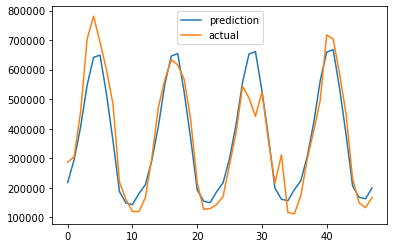

In [59]:
comparison = pd.DataFrame(sarima_predictions)
comparison["actual"] = pd.Series(test_data["num_visitors"].values, index=comparison.index)
comparison = comparison.rename(columns={0:"prediction"})
comparison.plot();

In [ ]:
comparison.index = test_data.index

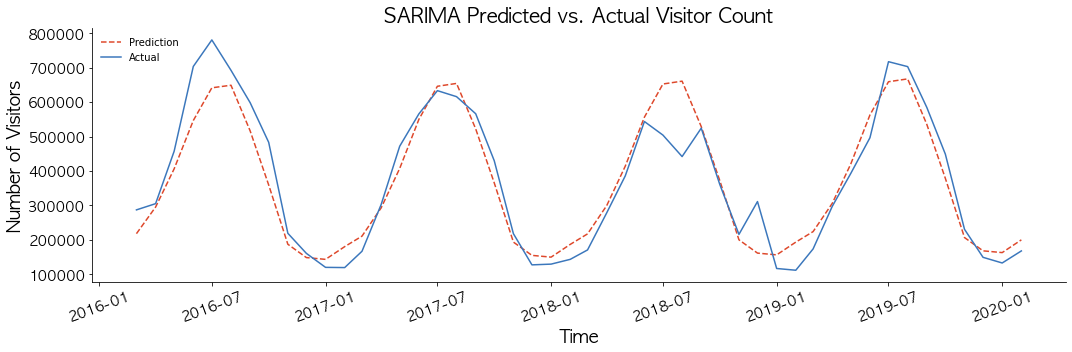

In [88]:
plt.figure(figsize=(15,5))

plt.plot(comparison.index, comparison["prediction"], label="prediction", color='#DE482B', linestyle='--')
sns.lineplot(x=comparison.index, y=comparison["actual"], label="actual", color='#3B77BC')

sns.despine(top=True, right=True)

legend = plt.legend(bbox_to_anchor=(0,1), loc="upper left", frameon=False)
legend.texts[0].set_text("Prediction")
legend.texts[1].set_text("Actual")

plt.title("SARIMA Predicted vs. Actual Visitor Count", fontsize=20, fontname="AppleGothic")

plt.xlabel("Time", fontname="AppleGothic", fontsize=18)
plt.ylabel("Number of Visitors", fontname="AppleGothic", fontsize=18)

plt.xticks(rotation=20, fontname="AppleGothic", fontsize=14)
plt.yticks(fontname="AppleGothic", fontsize=14)
plt.tight_layout()

plt.savefig('images/sarima_forecast.png', format='png', dpi=400, transparent=True);

In [ ]:
top_10_park_codes = ['ACAD',
 'GLAC',
 'GRCA',
 'GRTE',
 'GRSM',
 'OLYM',
 'ROMO',
 'YELL',
 'YOSE',
 'ZION']

In [ ]:
# save fitted sarima models
for park in top_10_park_codes:
    
    park_df = prep_data(park)
    
    sarima_model = save_sarima(park_df, 48, park)
    
    with open(f"model_data/{park}_sarima.pickle", "wb") as write_file:
        pickle.dump(sarima_model, write_file)

Now my goal is to create a figure to compare the error rates between the different time series models. This is done after the neural net models metrics have been calculated.

In [ ]:
# open up mean absolute percent error model metrics
model_error_df = pd.read_pickle("model_data/model_error_df.pickle")
nn_model_error_df = pd.read_pickle("model_data/nn_model_error_df.pickle")

# combine the dataframes
combined_df = pd.merge(model_error_df, nn_model_error_df, on="park_code")
combined_df.index = combined_df["park_code"]

# dropping ARIMA error column because the errors are extremely large and SARIMA performs much better
combined_df.drop(columns=["park_code", "ARIMA_mape"], inplace=True)

# stack the dataframe so each row is a park and model
stacked_df = pd.DataFrame(combined_df.stack()).reset_index()
stacked_df.columns = ["park_code", "model", "mape"]

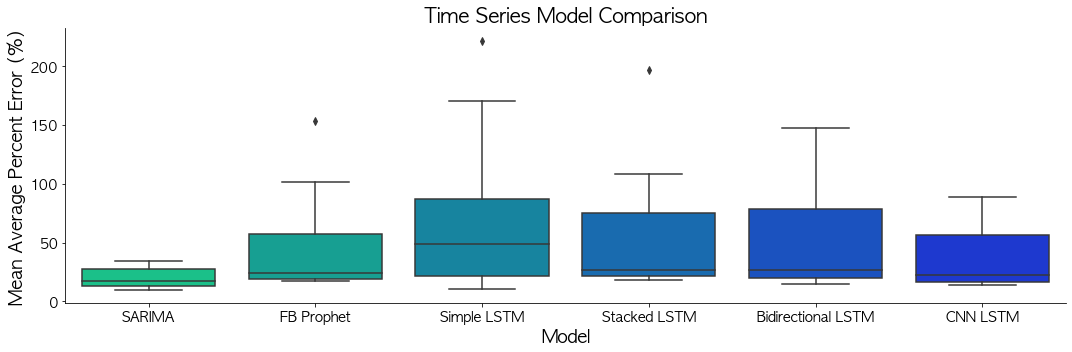

In [89]:
plt.figure(figsize=(15,5))
sns.boxplot(x="model", y="mape", data=stacked_df, palette='winter_r')
sns.despine(top=True, right=True)

plt.title("Time Series Model Comparison", fontsize=20, fontname="AppleGothic")

plt.xlabel("Model", fontsize=18, fontname="AppleGothic")
plt.ylabel("Mean Average Percent Error (%)", fontsize=18, fontname="AppleGothic")

tick_names = [0,1,2,3,4,5]
tick_labels = ["SARIMA", "FB Prophet", "Simple LSTM", "Stacked LSTM", "Bidirectional LSTM", "CNN LSTM"]

plt.xticks(ticks=tick_names, labels=tick_labels, fontsize=14, fontname="AppleGothic")
plt.yticks(fontsize=14, fontname="AppleGothic")

plt.tight_layout()
plt.savefig('images/model_comparison.png', format='png', dpi=400, transparent=True);